In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:

# Split dataset (if not already done)
train_src =r'E:\sanju\ASL_Alphabet_Dataset\asl_alphabet_train'
splitfolders.ratio(train_src, output="datasets/asl_alphabets", seed=1337, ratio=(.8, .1, .1), move=False)

Copying files: 223074 files [04:29, 826.34 files/s] 


In [3]:


# Paths
train_dir = r'E:\sanju\datasets\asl_alphabets\train'
val_dir   = r'E:\sanju\datasets\asl_alphabets\val'
test_dir  = r'E:\sanju\datasets\asl_alphabets\test'
input_shape = (32, 32, 1)
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)

# Labels
labels = list(train_generator.class_indices.keys())
num_classes = len(labels)





Found 178447 images belonging to 29 classes.
Found 22295 images belonging to 29 classes.
Found 22332 images belonging to 29 classes.


In [5]:
# 🔨 CNN Architecture (Improved)
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # Output will be 32x32x32
    Dropout(0.25), # Start with a moderate dropout

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # Output will be 16x16x64
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 678,365 (2.59 MB)

 Trainable params: 677,277 (2.58 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [7]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)



In [8]:
# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1146 - loss: 3.3259
Epoch 1: val_accuracy improved from -inf to 0.51985, saving model to best_model.keras
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 330s 58ms/step - accuracy: 0.1146 - loss: 3.3258 - val_accuracy: 0.5198 - val_loss: 1.6723 - learning_rate: 0.0010
Epoch 2/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5006 - loss: 1.8194
Epoch 2: val_accuracy improved from 0.51985 to 0.74981, saving model to best_model.keras
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 388s 70ms/step - accuracy: 0.5006 - loss: 1.8194 - val_accuracy: 0.7498 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 3/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6424 - loss: 1.3688
Epoch 3: val_accuracy improved from 0.74981 to 0.78228, saving model to best_model.keras
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 351s 63ms/step - accuracy: 0.6424 - loss: 1.3688 - val_accuracy: 0.7823 - val_loss: 0.9101 - learning_rate: 0.0010
Epoch 4/30
5577/5577 ━━━━━━━━━━

In [9]:

# Save final model
model.save("NEW_MODEL.keras")

In [11]:
from tensorflow.keras.models import load_model

loaded_model = load_model('NEW_MODEL.keras')

last_completed_epoch = 29 # If you ran for epochs=30, the last completed epoch index is 29.

history_continued = loaded_model.fit(
    train_generator,
    epochs=55, # Total epochs you want to reach (e.g., if you want to run for 30 more, total will be 60)
    initial_epoch=last_completed_epoch + 1, # Start from the next epoch index
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr] # You can continue using the same checkpoint callback
)

Epoch 31/55
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8947 - loss: 0.3872
Epoch 31: val_accuracy improved from 0.95555 to 0.95569, saving model to best_model.keras
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 780s 138ms/step - accuracy: 0.8947 - loss: 0.3872 - val_accuracy: 0.9557 - val_loss: 0.2116 - learning_rate: 1.2500e-04
Epoch 32/55
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8953 - loss: 0.3819
Epoch 32: val_accuracy did not improve from 0.95569
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 903s 162ms/step - accuracy: 0.8953 - loss: 0.3819 - val_accuracy: 0.9539 - val_loss: 0.2137 - learning_rate: 1.2500e-04
Epoch 33/55
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8949 - loss: 0.3815
Epoch 33: val_accuracy improved from 0.95569 to 0.95699, saving model to best_model.keras
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 897s 161ms/step - accuracy: 0.8949 - loss: 0.3815 - val_accuracy: 0.9570 - val_loss: 0.2053 - learning_rate: 1.2500e-04
Epoch 34/55
5577/5577 ━━━━━━━━━━━━━━━━━━━━

In [12]:
model.save("NEW_MODEL_EXTENDED.keras")

In [13]:
model.evaluate(test_generator)

698/698 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - accuracy: 0.9548 - loss: 0.2099


[0.19880878925323486, 0.9584452509880066]

In [14]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    """
    Load and preprocess the image to match model input
    """
    img = image.load_img(img_path, color_mode='grayscale', target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted: E (61.87%)


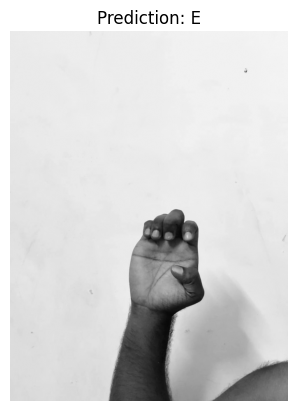

In [29]:
class_labels = list(train_generator.class_indices.keys())
def predict_asl(img_path):
    """
    Predict the ASL class for a given image path
    """
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    predicted_label = class_labels[class_index]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")

    # Show the image
    plt.imshow(image.load_img(img_path, color_mode='grayscale'), cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()

# Example usage
predict_asl(r"C:\Users\ramch\Downloads\E.jpg")